# Cheng Hsuan Chiang 
# ID: 12283758
# Homework4: Return Predictions From Trade Flow

## University of Chicago - Financial Mathematics
## FINM 33150 - Regression Analysis and Quantitative Trading Strategies

## This was worked on with Richmond Frankeberger and Imtiaz Ali

# 0. Introduction(Flow calculation / Forward Return calculation / prediction)

**Here you will assess trade flow as means of generating profit opportunities in 3 cryptotoken markets(BTCUSD, ETHUSD, and ETHBTC) from CoinBase Websocket API for 2021.<br>
We stress the word "opportunity" because at high data rates like these, and given the markets' price-time priority, it is far easier to identify desirable trades in the data stream than it is to inject oneself profitably into the fray.**

## 0.1 Flow Calculation

$F_{t}^{(\tau)} = V_{t-\tau, t}^{B} - V_{t-\tau, t}^{S}$

$V^B$ - volume of buyer-initiated trades;

$V^S$ - volume of seller-initiated trades;

$F_t^{(\tau)}$ - flow corresponding to time $t$;

$\tau$ - threshold for flow calculation;

## 0.2 Forward Return calculation

$$ r_t = \frac{P_{t+T}}{P_t} - 1 $$

$P_t$ - price of the asset at current time stamp $t$;

$P_{t+T}$ - price of the asset $T$ seconds from current time stamp $t$;

$T$ - threshold for forward return calculation;

## 0.3 Regression(regress forward returns on flows)

$$ r_t = \beta \cdot F_t^{(\tau)} + \alpha $$

## 0.4 Forward Return prediction (predict future forward returns by multiplying estimated $\beta$ on actual flows)

$$ \hat{r}_i = \beta \cdot F_i^{(\tau)} $$

# 1. Data Processing

**First we retrieve all necessary packages, imports and Functions:**

In [1]:
%matplotlib inline
import pandas                    as     pd
import numpy                     as     np
import seaborn                   as     sns
import statsmodels.api           as     sm
import scipy
import sys
import requests
import time
import pytz
from   matplotlib                import pyplot as plt
from   datetime                  import datetime
from   datetime                  import timedelta
from   p_tqdm                    import p_map,t_map
from   tqdm.notebook             import tqdm
from   os.path                   import exists
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.display.float_format = '{:.6f}'.format

**We will define a function for importing crypto data locally**

In [2]:
## We will define a function for importing crypto data locally. 
## pair: cryptoken pair 
def extract_data(pair):           
    if pair == "ETH-USD":
        df                       = pd.read_csv(f"trades_narrow_ETH-USD_2021.delim", delimiter="\t")
    elif pair == "BTC-USD":
        df                       = pd.read_csv(f"trades_narrow_BTC-USD_2021.delim", delimiter="\t")
    elif pair == "ETH-BTC":
        df                       = pd.read_csv(f"trades_narrow_ETH-BTC_2021.delim", delimiter="\t")    
    df.timestamp_utc_nanoseconds = pd.to_datetime(df.timestamp_utc_nanoseconds)
    df                           = df.set_index("timestamp_utc_nanoseconds")
    return df

In [3]:
ETHUSD_trades = extract_data("ETH-USD")
BTCUSD_trades = extract_data("BTC-USD")
ETHBTC_trades = extract_data("ETH-BTC")

### 1.1 We will search for what values of tau and T are the most profitable to trade

**The optimization of tau and T are key in assessing trading opportunities. We will do gridsearch of tau and T in assessing trading opportunities.**

**Based on professor Brian's recommendation on the choice of timeframe of tau and T in class, professor Brian recommended the choice of timeframe from 1 second to 60 seconds.<br>
We will simulate 1 second as the bottom parameter, and up to 60 seconds for the top parameter. We will choose tau and T from combinations of 1, 2, 10, 30, and 60 seconds.**

In [4]:
taus = [1,2,10,30,60]
Ts   = [1,2,10,30,60]

**We will calculate trade flow and save the calculation into csv.**

In [5]:
def calulation_trade_flow_and_csv_preperation(trades,pair,tau,T):
    ## We will calculate trade flow and save the calculation into csv if there is not there already.
    if not exists("{}_tau_{}_T_{}_seconds.csv".format(pair,tau,T)):
        df_trade                   = trades
        df_tradeoriginal           = df_trade.copy()
        df_trade                   = df_trade.assign(Flow = (df_trade['SizeBillionths'] * (df_trade['Side'] < 0 )- df_trade['SizeBillionths']*(df_trade['Side'] > 0 )).cumsum())
        
        df_trade_lookback          = df_trade.copy()
        df_trade_lookback.index    = df_trade_lookback.index  - timedelta(seconds = tau)
        
        df_flowcaculation          = pd.concat([df_trade['Flow'].to_frame('Flow_tau_end'),df_trade_lookback['Flow'].to_frame('Flow_start')],0)
        df_flowcaculation          = df_flowcaculation.sort_index(kind='stable').fillna(method='ffill')
        df_flowcaculation          = df_flowcaculation.assign(Flow   = df_flowcaculation['Flow_tau_end'] - df_flowcaculation['Flow_start'])        
        df_flowcaculation_final    = pd.merge_asof(df_tradeoriginal,df_flowcaculation,left_index=True,right_index=True)
        
        df_test                    = df_flowcaculation_final.copy()[['PriceMillionths','SizeBillionths']]
        df_test                    = df_test.assign(dolvol        = df_test['PriceMillionths'] / 1000000000 * df_test['SizeBillionths'])
        df_test                    = df_test.groupby(df_test.index).agg('sum')
        
        df_test                    = df_test.assign(WeightPx      = df_test['dolvol'] / df_test['SizeBillionths'] * 1000000000)
        df_test                    = df_test[['WeightPx']]
        df_test                    = df_test.assign(WeightPxStart = df_test['WeightPx'].rolling('{}s'.format(T),closed='left').mean().ffill())
        
        df_trade_flow_preperation  = pd.merge_asof(df_flowcaculation_final,df_test,left_index=True,right_index=True)
        df_trade_flow_preperation  = df_trade_flow_preperation.assign(Ret = df_trade_flow_preperation['PriceMillionths'] / df_trade_flow_preperation['WeightPxStart'] - 1)
        df_trade_flow_preperation  = df_trade_flow_preperation.reset_index()
        df_trade_flow_preperation  = df_trade_flow_preperation[['timestamp_utc_nanoseconds','Flow','Ret']]               
        
        filename                   = "{}_tau_{}_T_{}_seconds.csv".format(pair,tau,T)
        df_trade_flow_preperation.to_csv(filename)

**We will define a function to run linear regression, prediction, and profitability analysis**

In [6]:
def calulation_trade_flow_and_return(period,trades,pair,tau,T):
    ## We will seperate our flow data into train and test set
    df_trade_flow_preperation                        = pd.read_csv("{}_tau_{}_T_{}_seconds.csv".format(pair,tau,T))
    df_train                                         = df_trade_flow_preperation.iloc[:int(df_trade_flow_preperation.shape[0] * period),:]
    df_test                                          = df_trade_flow_preperation.iloc[int(df_trade_flow_preperation.shape[0] * period):,:]
    
    return_train, flow_train, return_test, flow_test = df_train['Ret'], df_train['Flow'], df_test['Ret'], df_test['Flow']
    independent_variable_add_constant_train          = sm.add_constant(flow_train/1000000000)
    independent_variable_add_constant_test           = sm.add_constant(flow_test /1000000000)
    Regression                                       = sm.OLS(return_train,independent_variable_add_constant_train,missing='drop').fit()
    Prediction                                       = Regression.predict(independent_variable_add_constant_test)                        
    regression_stats                                 = pd.DataFrame(index=['Strat_Ret'],columns=[r'Out of Sample $R^2$',r'$R^2$','Alpha','Beta'])
    regression_stats['Alpha']                        = Regression.params['const']
    regression_stats['Beta']                         = Regression.params[1]
    regression_stats[r'$R^2$']                       = Regression.rsquared
    sum_squared_regression_ssr                       = return_test - Prediction
    total_sum_of_squares_sst                         = return_test - return_test.mean()    
    ssr                                              = (sum_squared_regression_ssr ** 2).sum()
    sst                                              = (total_sum_of_squares_sst ** 2).sum()
    out_of_sample_rsquared                           = 1 - ssr/sst    
    regression_stats[r'Out of Sample $R^2$']         = out_of_sample_rsquared
        
    df_test                                          = df_test.assign(Pred_Return  = df_test['Flow']/ 1000000000 * regression_stats['Beta'][0] + regression_stats['Alpha'][0])
    df_test                                          = df_test.assign(j_upper      = df_test['Pred_Return'].mean() + df_test['Pred_Return'].std()*0.5)
    df_test                                          = df_test.assign(j_lower      = df_test['Pred_Return'].mean()   - df_test['Pred_Return'].std()*0.5)
    j_upper                                          = df_test['Pred_Return'].mean() + df_test['Pred_Return'].std()*0.5
    j_lower                                          = df_test['Pred_Return'].mean() - df_test['Pred_Return'].std()*0.5

    df_test                                          = df_test.assign(Position = (df_test['Pred_Return'] > df_test['j_upper']) * 1  - (df_test['Pred_Return'] < df_test['j_lower']) * 1)
    df_test                                          = df_test.assign(PL_DLY   = (df_test['Position']  * (df_test['Ret']) * 10000))
    df_test                                          = df_test.assign(Cumulative_PNL   = df_test['PL_DLY'].cumsum())

    df_test                                          = df_test.set_index("timestamp_utc_nanoseconds")
    df_test                                          = df_test.assign(Strat_Ret = (df_test['PL_DLY'])/(df_test['Cumulative_PNL']+1000000))
    df_returns                                       = df_test[['Strat_Ret']]
    df_analysis                                      = pd.DataFrame(index=df_test[['Strat_Ret']].columns)
    df_analysis['Sharpe Ratio']                      = (df_returns.mean()/df_returns.std())
    df_analysis['Sortino Ratio']                     = (df_returns.mean()/df_returns[df_returns< 0].std())
    df_performance                                   = df_analysis
    df_performance                                   = df_performance.assign(Cumulative_PNL     = df_test['Cumulative_PNL'][-1])
    results                                          = regression_stats.join(df_performance).T
        
    return df_train, df_test, results

In [7]:
def evaluation(period,trades,pair,taus,Ts):
    concatlist = []
    for tau in taus:
        for T in Ts:
            calulation_trade_flow_and_csv_preperation(trades,pair,tau,T)          
            df_train, df_test, results = calulation_trade_flow_and_return(period,trades,pair,tau,T)
            results = results.rename(columns={'Strat_Ret':'T={}, tau={}, {}'.format(T,tau,pair)})
            concatlist.append(results)
    return pd.concat(concatlist,axis = 1).T

In [8]:
ETHUSD_performance_table    = evaluation(0.2,ETHUSD_trades,"ETHUSD",taus,Ts)
ETHUSD_performance_table_30 = evaluation(0.3,ETHUSD_trades,"ETHUSD",taus,Ts)
ETHUSD_performance_table_40 = evaluation(0.4,ETHUSD_trades,"ETHUSD",taus,Ts)
ETHUSD_performance_table_50 = evaluation(0.5,ETHUSD_trades,"ETHUSD",taus,Ts)
ETHUSD_performance_table_60 = evaluation(0.6,ETHUSD_trades,"ETHUSD",taus,Ts)

In [9]:
BTCUSD_performance_table    = evaluation(0.2,BTCUSD_trades,"BTCUSD",taus,Ts)
BTCUSD_performance_table_30 = evaluation(0.3,BTCUSD_trades,"BTCUSD",taus,Ts)
BTCUSD_performance_table_40 = evaluation(0.4,BTCUSD_trades,"BTCUSD",taus,Ts)
BTCUSD_performance_table_50 = evaluation(0.5,BTCUSD_trades,"BTCUSD",taus,Ts)
BTCUSD_performance_table_60 = evaluation(0.6,BTCUSD_trades,"BTCUSD",taus,Ts)

In [10]:
ETHBTC_performance_table    = evaluation(0.2,ETHBTC_trades,"ETHBTC",taus,Ts)
ETHBTC_performance_table_30 = evaluation(0.3,ETHBTC_trades,"ETHBTC",taus,Ts)
ETHBTC_performance_table_40 = evaluation(0.4,ETHBTC_trades,"ETHBTC",taus,Ts)
ETHBTC_performance_table_50 = evaluation(0.5,ETHBTC_trades,"ETHBTC",taus,Ts)
ETHBTC_performance_table_60 = evaluation(0.6,ETHBTC_trades,"ETHBTC",taus,Ts)

In [11]:
print('ETH/USD Trades Total: %d' % len(ETHUSD_trades))
print('BTC/USD Trades Total: %d' % len(BTCUSD_trades))
print('ETH/BTC Trades Total: %d' % len(ETHBTC_trades))

ETH/USD Trades Total: 306798
BTC/USD Trades Total: 6268838
ETH/BTC Trades Total: 32744


# 2.Trading Strategy Implementation

###  2.0.1 We will calculate simulation of Profit and Loss

**Professor Brian mentioned on ed that it is too time-consuming to do a trading strategy here.  There's a lot of data, and at the tick level the analyses and assumptions get tricky.  And it is impossible to vectorize.<br>**

**We will calculate Profit and Loss by assuming initaI Capital of 1million and each trade is about 10thousands. Although calculating Profit and Loss is difficult, we will try to analyze the profitability of collections of observed trades. Our analysis will have the flavor of a trading strategy backtest by incorporating some vectorizable ideas.  The objective of our analysis is to get an idea of a performance metrics.**

###  2.0.2 We will define threshold j for predicted return

**Our tick trading strategy will set threshold j for 0.5 standard deviation sigma away from the mean of predicted returns and the mean and standard deviation or return will be based on the training dataset.<br>**

**When the predicted return is greater than predicted return mean plus 0.5 standard deviation, we will enter into the position of buying the numerator and shorting the denominator, and we will exit the position at time T.<br>
When the predicted return is smaller than predicted return mean minus 0.5 standard deviation, we will enter into the position of selling the numerator and buying the denominator, and we will exit the position at time T.**

## 2.1 ETHUSD

We can see from the table below that trading strategy when applied to ETHUSD cryptocurrency pair shows the best results when we use the following parameters: $\tau = 30, T = 60$ seconds

**Where of tau = 30 and T = 60 had an R^2 of 10% and Out of Sample R^2 of 17%.**

- **Cumulative PnL = \$239,939** 

- **Sharpe Ratio = 0.24** with zero as a benchmark for its calculation (i.e. $r_b = 0$). It tells us that performance of our trading strategy taking into account the OVERALL risk of our strategy is above the benchmark, and we have positive excess returns, i.e. in general we can just say that we have positive returns as benchmark is $0$.


- **Sortino Ratio = 0.29** with zero as a benchmark for its calculation (i.e. $r_b = 0$). It tells us that performance of our trading strategy taking into account ONLY the DOWNSIDE RISK of our strategy (measured by standard deviation of positions with negative returns) is above zero, and we have positive returns adjusted for downside risk. As Sortino Ratio is higher than Sharpe Ratio we can say that trading stretegy performs better in downturns than in upturns taking into consideration underlying risk. 

- **Beta = -0.000003** and tells us that there is a negative relationahip between Flow and Forward returns, and in particular, forward retuns decrease by 0.000003 (0.003\%) for every 1 bp increase in the Flow.

Taking into consideration common benchmark values for Sharpe and Sortino ratios and the fact that those ratios for our trading strategy are less than 1, we can say that returns delivered by this trading strategy on ETHUSD pair do not make up for the amount of underlying risk.

In [12]:
ETHUSD_performance_table.sort_values(r'Cumulative_PNL',ascending=False).head(5)

,Out of Sample $R^2$,$R^2$,Alpha,Beta,Sharpe Ratio,Sortino Ratio,Cumulative_PNL
"T=60, tau=30, ETHUSD",0.174150,0.101128,0.000018,-0.000003,0.243390,0.294098,239939.645547
"T=60, tau=60, ETHUSD",0.160347,0.089396,0.000019,-0.000002,0.226245,0.249007,228424.244820
"T=60, tau=10, ETHUSD",0.117810,0.067185,0.000016,-0.000003,0.204483,0.202346,187089.077696
"T=30, tau=30, ETHUSD",0.152715,0.089425,0.000007,-0.000002,0.212210,0.190060,154058.879013
"T=30, tau=10, ETHUSD",0.136171,0.084480,0.000007,-0.000003,0.209905,0.229907,142815.424498


**When we plotted Flow versus predicted return, we found that linear relationship between ETHUSD flow and predicted return is not that obvious.**

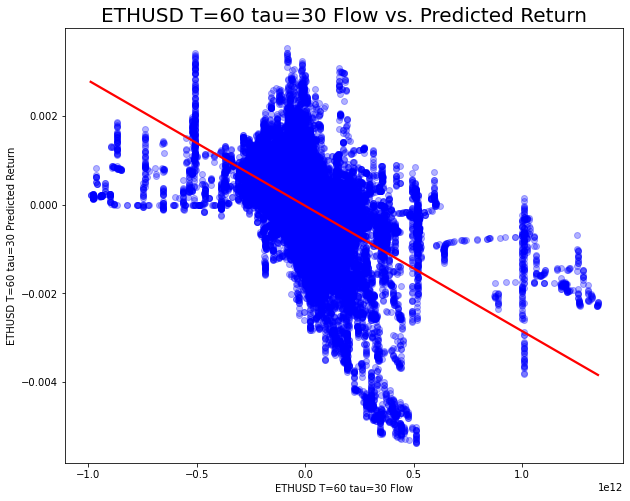

In [13]:
df_train_ETHUSD_T_60_tau_30, df_test_ETHUSD_T_60_tau_30, results_ETHUSD_T_60_tau_30 = calulation_trade_flow_and_return(0.2,ETHUSD_trades,"ETHUSD",30,60)
plt.figure(figsize = (10,8))
sns.regplot(df_test_ETHUSD_T_60_tau_30['Flow'], df_test_ETHUSD_T_60_tau_30['Ret'], ci = None, scatter_kws={"color": "blue", 'alpha': 0.3}, line_kws={"color": "red"})
plt.ylabel('ETHUSD T=60 tau=30 Predicted Return')
plt.xlabel('ETHUSD T=60 tau=30 Flow')
plt.title('ETHUSD T=60 tau=30 Flow vs. Predicted Return', fontsize = 20)
plt.show()

## 2.2 BTCUSD

We can see from the table below that trading strategy when applied to BTCUSD cryptocurrency pair shows the best results when we use the following parameters: $\tau = 30, T = 60$ seconds

**Where of tau = 30 and T = 60 had an R^2 of 25% and Out of Sample R^2 of 29%.**

- **Cumulative PnL = \$	14,137,602** 

- **Sharpe Ratio = 0.15** with zero as a benchmark for its calculation (i.e. $r_b = 0$). It tells us that performance of our trading strategy taking into account the OVERALL risk of our strategy is above the benchmark, and we have positive excess returns, i.e. in general we can just say that we have positive returns as benchmark is $0$.


- **Sortino Ratio = 0.11** with zero as a benchmark for its calculation (i.e. $r_b = 0$). It tells us that performance of our trading strategy taking into account ONLY the DOWNSIDE RISK of our strategy (measured by standard deviation of positions with negative returns) is above zero, and we have positive returns adjusted for downside risk. 

- **Beta = -0.000033** and tells us that there is a negative relationahip between Flow and Forward returns, and in particular, forward retuns decrease by 0.000033 (0.033\%) for every 1 bp increase in the Flow.

**Taking into consideration common benchmark values for Sharpe and Sortino ratios and the fact that those ratios for our trading strategy are less than 1, we can say that returns delivered by this trading strategy on BTCUSD pair do not make up for the amount of underlying risk.**

In [14]:
BTCUSD_performance_table.sort_values(r'Cumulative_PNL',ascending=False).head(5)

,Out of Sample $R^2$,$R^2$,Alpha,Beta,Sharpe Ratio,Sortino Ratio,Cumulative_PNL
"T=60, tau=30, BTCUSD",0.286136,0.251303,-0.000010,-0.000033,0.150049,0.110204,14137602.817218
"T=60, tau=10, BTCUSD",0.196751,0.200939,-0.000003,-0.000053,0.138757,0.093373,12502956.373131
"T=60, tau=60, BTCUSD",0.255536,0.197339,-0.000013,-0.000020,0.131565,0.088542,11870630.114982
"T=30, tau=10, BTCUSD",0.219671,0.231659,-0.000002,-0.000041,0.154826,0.115476,9164216.009120
"T=30, tau=30, BTCUSD",0.236203,0.216668,-0.000006,-0.000022,0.142199,0.091614,8653974.080846


**When we plotted Flow versus predicted return, we found that linear relationship between BTCUSD flow and predicted return is the most obvious among three pairs.**

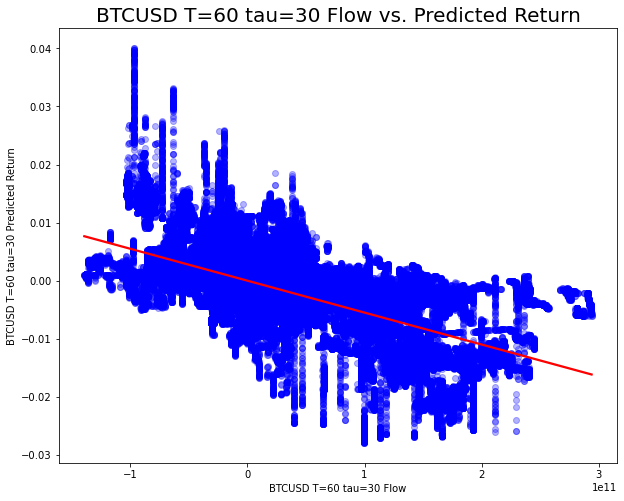

In [15]:
df_train_BTCUSD_T_60_tau_30, df_test_BTCUSD_T_60_tau_30, results_BTCUSD_T_60_tau_30 = calulation_trade_flow_and_return(0.2,BTCUSD_trades,"BTCUSD",30,60)
plt.figure(figsize = (10,8))
sns.regplot(df_test_BTCUSD_T_60_tau_30['Flow'], df_test_BTCUSD_T_60_tau_30['Ret'], ci = None, scatter_kws={"color": "blue", 'alpha': 0.3}, line_kws={"color": "red"})
plt.ylabel('BTCUSD T=60 tau=30 Predicted Return')
plt.xlabel('BTCUSD T=60 tau=30 Flow')
plt.title('BTCUSD T=60 tau=30 Flow vs. Predicted Return', fontsize = 20)
plt.show()

## 2.3 ETHBTC

ETH-BTC is thinly traded.  But the other data sets have far more frequent trades.

We can see from the table below that trading strategy when applied to ETHBTCU cryptocurrency pair shows the best results when we use the following parameters: $\tau = 30, T = 60$ seconds

**Where of tau = 30 and T = 60 had an R^2 of 3.5% and Out of Sample R^2 of 3.2%. Both are very small, the regression model of ETH did not do well and their betas are all not that reliable.**

- **Cumulative PnL = \$9,405** 

- **Sharpe Ratio = 0.17** with zero as a benchmark for its calculation (i.e. $r_b = 0$). It tells us that performance of our trading strategy taking into account the OVERALL risk of our strategy is above the benchmark, and we have positive excess returns, i.e. in general we can just say that we have positive returns as benchmark is $0$.


- **Sortino Ratio = 0.20** with zero as a benchmark for its calculation (i.e. $r_b = 0$). It tells us that performance of our trading strategy taking into account ONLY the DOWNSIDE RISK of our strategy (measured by standard deviation of positions with negative returns) is above zero, and we have positive returns adjusted for downside risk. As Sortino Ratio is higher than Sharpe Ratio we can say that trading stretegy performs better in downturns than in upturns taking into consideration underlying risk. 

- **Beta = -0.000008** and tells us that there is a negative relationahip between Flow and Forward returns, and in particular, forward retuns decrease by 0.000008 (0.008\%) for every 1 bp increase in the Flow.

**From our understanding, the inaccuracy of the regression is caused because compared with ETHUSD and BTCUSD, ETHBTC is relatively thinly trade. Because there are too many noises in the market, the relatively lack of training data might cause the inaccuracy**.

**Taking into consideration common benchmark values for Sharpe and Sortino ratios and the fact that those ratios for our trading strategy are less than 1, we can say that returns delivered by this trading strategy on ETHBTC pair do not make up for the amount of underlying risk.**

In [16]:
ETHBTC_performance_table.sort_values(r'Cumulative_PNL',ascending=False).head(5)

,Out of Sample $R^2$,$R^2$,Alpha,Beta,Sharpe Ratio,Sortino Ratio,Cumulative_PNL
"T=60, tau=30, ETHBTC",0.032326,0.034845,-0.000009,-0.000008,0.170305,0.198576,9405.447624
"T=60, tau=60, ETHBTC",0.031079,0.028852,-0.000010,-0.000005,0.143070,0.152089,8759.929523
"T=60, tau=10, ETHBTC",0.019229,0.035788,-0.000006,-0.000011,0.166077,0.160191,7787.517533
"T=60, tau=2, ETHBTC",0.015903,0.034679,-0.000005,-0.000014,0.146300,0.059609,6223.251492
"T=30, tau=10, ETHBTC",0.007017,0.037165,-0.000004,-0.000009,0.165995,0.174198,6221.467434


**When we plotted Flow versus predicted return, we did not find linear relationship between ETHBTC flow and predicted return.**

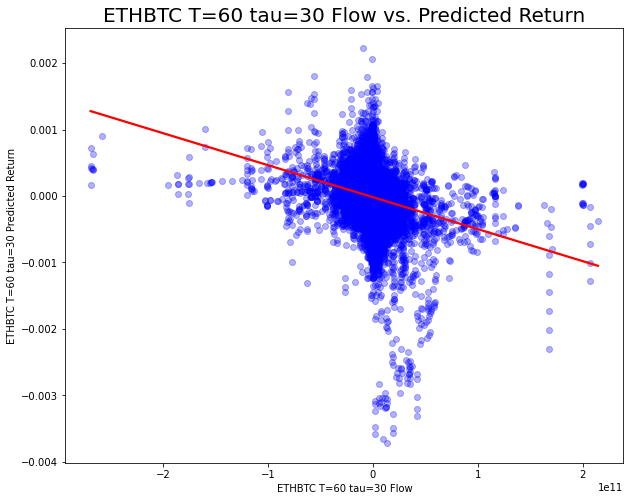

In [17]:
df_train_ETHBTC_T_60_tau_30, df_test_ETHBTC_T_60_tau_30, results_ETHBTC_T_60_tau_30 = calulation_trade_flow_and_return(0.2,ETHBTC_trades,"ETHBTC",30,60)
plt.figure(figsize = (10,8))
sns.regplot(df_test_ETHBTC_T_60_tau_30['Flow'], df_test_ETHBTC_T_60_tau_30['Ret'], ci = None, scatter_kws={"color": "blue", 'alpha': 0.3}, line_kws={"color": "red"})
plt.ylabel('ETHBTC T=60 tau=30 Predicted Return')
plt.xlabel('ETHBTC T=60 tau=30 Flow')
plt.title('ETHBTC T=60 tau=30 Flow vs. Predicted Return', fontsize = 20)
plt.show()

# 3. Analysis

## 3.1 Much longer training and test period? Using longer training periods to 30%,40%,50%,60% 

**Cryptotoken market is a market with no underlying, so it is less likely that informed diretional traders existed than the underlying markets, which means we could not be sure that along the five days we’re computing, the traders who were trading are informed traders.<br>**

**From our understandings, with much longer training and test period, the strategy will become less reliable and the return will be much less attempting.<br>**

###  3.1.1 ETHUSD longer traning period

**If we increase trainig period to 40% of the total data, where of tau = 30 and T = 60 had an R^2 of 10% and Out of Sample R^2 of 19%. Only a small improvement compared to 20% training period R^2 of 10% and Out of Sample R^2 of 17%.**

**If we increase trainig period to 50% of the total data, where of tau = 30 and T = 60 had an R^2 of 10% and Out of Sample R^2 of 18%, which is a small improvement compared to 20% training period R^2 of 10% and Out of Sample R^2 of 17%.**

In [18]:
ETHUSD_performance_table_30.sort_values(r'Cumulative_PNL',ascending=False).head(1)

,Out of Sample $R^2$,$R^2$,Alpha,Beta,Sharpe Ratio,Sortino Ratio,Cumulative_PNL
"T=60, tau=30, ETHUSD",0.183762,0.095250,0.000009,-0.000003,0.246635,0.302157,222399.825675


In [19]:
ETHUSD_performance_table_40.sort_values(r'Cumulative_PNL',ascending=False).head(1)

,Out of Sample $R^2$,$R^2$,Alpha,Beta,Sharpe Ratio,Sortino Ratio,Cumulative_PNL
"T=60, tau=30, ETHUSD",0.194148,0.099158,-0.000004,-0.000003,0.247159,0.305477,199457.663169


In [20]:
ETHUSD_performance_table_50.sort_values(r'Cumulative_PNL',ascending=False).head(1)

,Out of Sample $R^2$,$R^2$,Alpha,Beta,Sharpe Ratio,Sortino Ratio,Cumulative_PNL
"T=60, tau=30, ETHUSD",0.178991,0.099198,0.000000,-0.000002,0.255905,0.326245,184171.147050


In [21]:
ETHUSD_performance_table_60.sort_values(r'Cumulative_PNL',ascending=False).head(1)

,Out of Sample $R^2$,$R^2$,Alpha,Beta,Sharpe Ratio,Sortino Ratio,Cumulative_PNL
"T=60, tau=30, ETHUSD",0.187017,0.118738,0.000003,-0.000002,0.248007,0.322488,151926.247919


###  3.1.2 BTCUSD longer traning period

**If we increase trainig period to 30% of the total data, where of tau = 30 and T = 60 had an R^2 of 23% and Out of Sample R^2 of 27%, which is a small deterioration compared to 20% training period R^2 of 25% and Out of Sample R^2 of 29%.**

**If we increase trainig period to 40% of the total data, where of tau = 30 and T = 60 had an R^2 of 43% and Out of Sample R^2 of 13%, we can see that Out of sample R^2 deterioration compared to 20% training period R^2 of 25% and Out of Sample R^2 of 29%.**

In [22]:
BTCUSD_performance_table_30.sort_values(r'Cumulative_PNL',ascending=False).head(1)

,Out of Sample $R^2$,$R^2$,Alpha,Beta,Sharpe Ratio,Sortino Ratio,Cumulative_PNL
"T=60, tau=30, BTCUSD",0.265572,0.234110,-0.000017,-0.000029,0.135493,0.094160,13419447.020254


In [23]:
BTCUSD_performance_table_40.sort_values(r'Cumulative_PNL',ascending=False).head(1)

,Out of Sample $R^2$,$R^2$,Alpha,Beta,Sharpe Ratio,Sortino Ratio,Cumulative_PNL
"T=60, tau=30, BTCUSD",0.125207,0.433693,0.000005,-0.000068,0.218108,0.270438,8531943.840629


In [24]:
BTCUSD_performance_table_50.sort_values(r'Cumulative_PNL',ascending=False).head(1)

,Out of Sample $R^2$,$R^2$,Alpha,Beta,Sharpe Ratio,Sortino Ratio,Cumulative_PNL
"T=60, tau=30, BTCUSD",0.120215,0.419142,-0.000012,-0.000067,0.202913,0.304029,7296226.625366


In [25]:
BTCUSD_performance_table_60.sort_values(r'Cumulative_PNL',ascending=False).head(1)

,Out of Sample $R^2$,$R^2$,Alpha,Beta,Sharpe Ratio,Sortino Ratio,Cumulative_PNL
"T=60, tau=30, BTCUSD",0.113470,0.409313,-0.000012,-0.000067,0.174204,0.285884,6141255.169140


###  3.1.3 ETHBTC longer traning period

**If we increase trainig period to 60% of the total data, where of tau = 30 and T = 60 had an R^2 of 3.7% and Out of Sample R^2 of 5.4%, which is a small improvement compared to 20% training period R^2 of 3.5% and Out of Sample R^2 of 3.2%.**

In [26]:
ETHBTC_performance_table_30.sort_values(r'Cumulative_PNL',ascending=False).head(1)

,Out of Sample $R^2$,$R^2$,Alpha,Beta,Sharpe Ratio,Sortino Ratio,Cumulative_PNL
"T=60, tau=30, ETHBTC",0.041938,0.031053,-0.000006,-0.000007,0.174479,0.209344,8797.489811


In [27]:
ETHBTC_performance_table_40.sort_values(r'Cumulative_PNL',ascending=False).head(1)

,Out of Sample $R^2$,$R^2$,Alpha,Beta,Sharpe Ratio,Sortino Ratio,Cumulative_PNL
"T=60, tau=30, ETHBTC",0.050694,0.030965,-0.000003,-0.000005,0.175162,0.211668,7902.596059


In [28]:
ETHBTC_performance_table_50.sort_values(r'Cumulative_PNL',ascending=False).head(1)

,Out of Sample $R^2$,$R^2$,Alpha,Beta,Sharpe Ratio,Sortino Ratio,Cumulative_PNL
"T=60, tau=30, ETHBTC",0.052586,0.035860,-0.000008,-0.000005,0.175562,0.217430,6878.040930


In [29]:
ETHBTC_performance_table_60.sort_values(r'Cumulative_PNL',ascending=False).head(1)

,Out of Sample $R^2$,$R^2$,Alpha,Beta,Sharpe Ratio,Sortino Ratio,Cumulative_PNL
"T=60, tau=30, ETHBTC",0.053972,0.037171,-0.000009,-0.000005,0.176482,0.228961,5984.658989


## 3.2  Reliability of beta of regression model

To assess the the realiability of a regression model, there’re several statistics that we can take a look at:

R squared: R squared in regression analysis measures the proportion of variation in the dependent variable which is explained by the variation of independent variable. More often, we use Adjusted  to meansure the model since it makes correction and avoids some bias. The lower R squared is, the less accurate and reliable that the model could predict the relationship between the dependent and independent variables.

For ETHUSD:<br>
R squared:  R squared of 10% and Out of Sample R squared of 17%.<br>

For BTCUSD:<br>
R squared: R squared of 25% and Out of Sample R squared of 29%.<br>

For ETHBTC:<br>
R squared: R squared of 3.2% and Out of Sample R squared of 3.4%. Both are very small, the regression model of ETH did not do well and their betas are all not that reliable.

**From the result we get, the regression model for ETHUSD and BTCUSD did do well and their betas are reliable. However, the regression model for ETHBTC did not do well and their betas are not reliable.**

## 3.3  How to choose j in this strategy?

Intuitively, we want to choose j such that when predicted return is larger than j, predicted return's distribution is left-skewed; when predicted return is smaller than j,  predicted return's distribution is right-skewed.<br> 
We could not choose a too-large j since the threshold is too high to trade. Also, we could not choose a too-small j sinche when the threshold is too low, there's no point of having a threshold.<br>

# 4. Graph Comparison

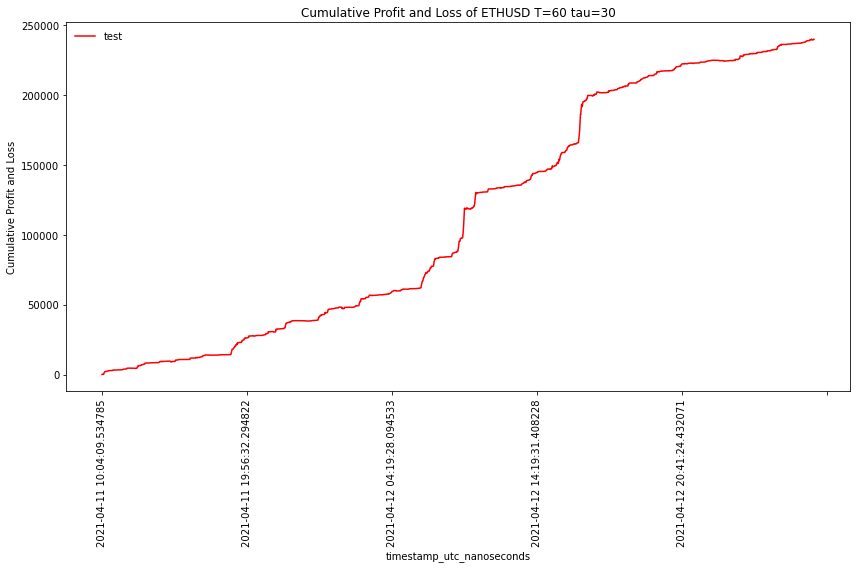

In [30]:
ETHUSD_tau_30_T_60_train,ETHUSD_tau_30_T_60_test,ETHUSD_tau_30_T_60_result =calulation_trade_flow_and_return(0.2,ETHUSD_trades,"ETHUSD",30,60)
plt.figure(figsize=(12, 8))
(ETHUSD_tau_30_T_60_test['Cumulative_PNL']).plot(c='r', label='test')
plt.xticks(ha='center', rotation=90)
plt.legend(frameon=False)
plt.ylabel('Cumulative Profit and Loss')
plt.title('Cumulative Profit and Loss of ETHUSD T=60 tau=30')
plt.tight_layout()
plt.show()
None

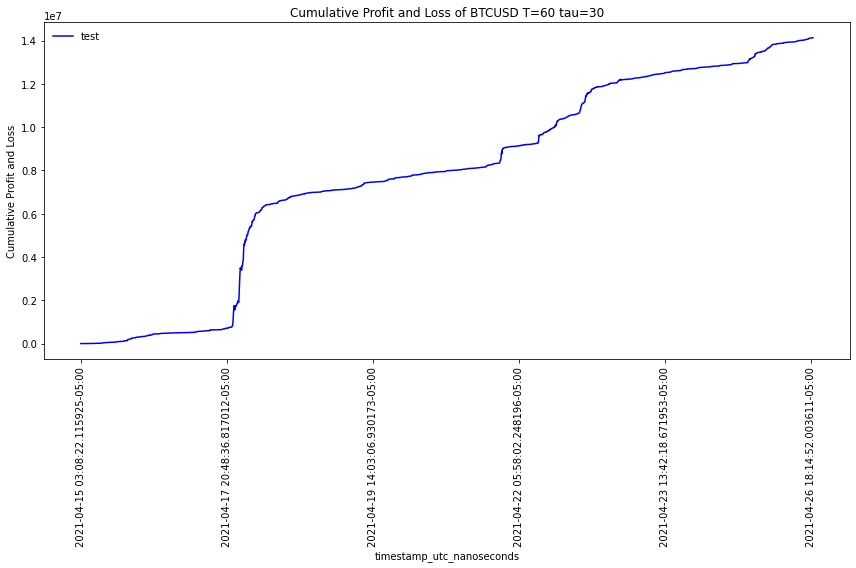

In [31]:
BTCUSD_tau_30_T_60_train,BTCUSD_tau_2_T_2_test,BTCUSD_tau_2_T_2_result =calulation_trade_flow_and_return(0.2,BTCUSD_trades,"BTCUSD",30,60)
plt.figure(figsize=(12, 8))
(BTCUSD_tau_2_T_2_test['Cumulative_PNL']).plot(c='b', label='test')
plt.xticks(ha='center', rotation=90)
plt.legend(frameon=False)
plt.ylabel('Cumulative Profit and Loss')
plt.title('Cumulative Profit and Loss of BTCUSD T=60 tau=30')
plt.tight_layout()
plt.show()
None

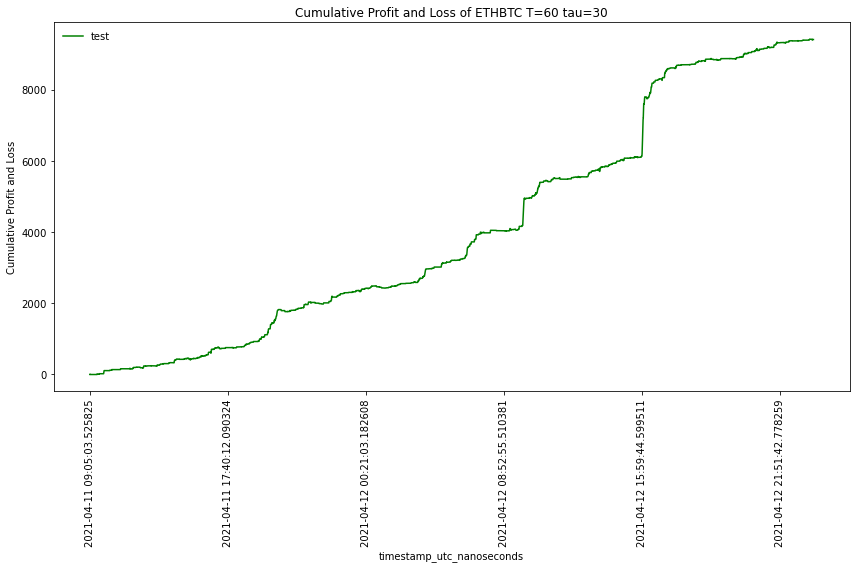

In [32]:
ETHBTC_tau_30_T_60_train,ETHBTC_tau_30_T_60_test,ETHBTC_tau_30_T_60_result =calulation_trade_flow_and_return(0.2,ETHBTC_trades,"ETHBTC",30,60)
plt.figure(figsize=(12, 8))
(ETHBTC_tau_30_T_60_test['Cumulative_PNL']).plot(c='g', label='test')
plt.xticks(ha='center', rotation=90)
plt.legend(frameon=False)
plt.ylabel('Cumulative Profit and Loss')
plt.title('Cumulative Profit and Loss of ETHBTC T=60 tau=30')
plt.tight_layout()
plt.show()
None

# 